## import stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')

import os
import collections
import glob

import scipy.optimize
import scipy.stats

## get data

In [2]:
mut_list = pd.read_csv('mut-list.csv',  sep=',', dtype={'geno' : str}, index_col=[0])
mut_list

,shortname,geno,h1_mean,h1_sem,h9_mean,h9_sem
a,1,"""10000000000""",7.534712,0.038504,7.000000,0.000000
b,2,"""01000000000""",7.000000,0.000000,7.000000,0.000000
c,"1,2","""11000000000""",9.278592,0.043819,9.067835,0.144001
d,6,"""00000100000""",7.000000,0.000000,7.000000,0.000000
e,"6,7","""00000110000""",7.958845,0.164461,8.869847,0.099096
g,"1,2,6,7","""11000110000""",9.343454,0.015493,9.807098,0.008562
h,"1,2,6,7,8","""11000111000""",9.364113,0.008849,10.001743,0.024947
m,0,"""00000000000""",7.000000,0.000000,7.000000,0.000000
n,11,"""11111111111""",9.506654,0.016688,10.094744,0.014203


In [3]:
run_list = pd.read_csv('run-list.csv')
run_list

,directory,row,shortname,mutant,antigen,replicate,prefix
0,../../Raw_facs_data/20210113,A,2,b,H1,1,NaN
1,../../Raw_facs_data/20210113,C,"1,2",c,H1,1,NaN
2,../../Raw_facs_data/20210113,E,6,d,H1,1,NaN
3,../../Raw_facs_data/20210113,B,"6,7",e,H1,1,NaN
4,../../Raw_facs_data/20210113,D,"1,2,6,7",g,H1,1,NaN
5,../../Raw_facs_data/20210115,A,1,a,H9,1,NaN
6,../../Raw_facs_data/20210115,C,"1,2",c,H9,1,NaN
7,../../Raw_facs_data/20210115,E,"6,7",e,H9,1,NaN
8,../../Raw_facs_data/20210115,B,"1,2,6,7",g,H9,1,NaN
9,../../Raw_facs_data/20210115,D,"1,2,6,7,8",h,H9,1,NaN


In [4]:
concentrations_list = pd.read_csv('concentrations-list.csv', index_col=[0])
cols = concentrations_list.index
concentrations_list

,H1,H9,H1_angela,H9_angela
well column,,,,
1,7.017969,7.002664,7.04646,7.019901
2,7.517969,7.502664,7.54646,7.519901
3,8.017969,8.002664,8.04646,8.019901
4,8.517969,8.502664,8.54646,8.519901
5,9.017969,9.002664,9.04646,9.019901
6,9.517969,9.502664,9.54646,9.519901
7,10.017969,10.002664,10.04646,10.019901
8,10.517969,10.502664,10.54646,10.519901
9,11.017969,11.002664,11.04646,11.019901


In [6]:
def get_run_jeff(run_id):
    run_row = run_list.loc[run_id,:]
    wells = ['%c%02d' % (run_row['row'], i) for i in range(1,13)]
#account for missing data
    if run_id == 3:
        # B7 didnt have any cells
        wells = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B08', 'B09', 'B10', 'B11', 'B12']
    if run_id == 4:
        # D7 didnt have any cells
        wells = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D08', 'D09', 'D10', 'D11', 'D12']
    if run_id == 10:
        # A12 didnt have any cells
        wells = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07','A08', 'A09', 'A10', 'A11','G3']
    if run_id == 11:
        # A12 didnt have any cells
        wells = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07','B08', 'B09', 'B10', 'B11','G3']
    if run_id == 12:
        # A12 didnt have any cells
        wells = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07','D08', 'D09', 'D10', 'D11','H3']
    if run_id == 13:
        # A12 didnt have any cells
        wells = ['E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07','E08', 'E09', 'E10', 'E11','H3']
    if run_id == 14:
        # A12 didnt have any cells
        wells = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07','A08', 'A09', 'A10', 'A11','G3']
    if run_id == 15:
        # A12 didnt have any cells
        wells = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07','B08', 'B09', 'B10', 'B11','G3']
    if run_id == 16:
        # A12 didnt have any cells
        wells = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07','D08', 'D09', 'D10', 'D11','H3']
    if run_id == 17:
        # A12 didnt have any cells
        wells = ['E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07','E08', 'E09', 'E10', 'E11','H3']
    def get_filename(well):
        search =  os.path.join(run_row['directory'], '*%s*' % well)
        filenames = glob.glob(search)
        if len(filenames) != 1:
            print(search, filenames)
            raise Exception(well)
        return filenames[0]

    read = pd.read_csv
        
    return [read(get_filename(well)) for well in wells]

def get_run(run_id):
    if pd.isna(run_list['prefix'])[run_id]:
        run = get_run_jeff(run_id)
    else:
        run = get_run_angela(run_id)
    #use compensated values
    if 'Comp-PE-A' in run[0]:
        for df in run:
            df['PE-A'] = df['Comp-PE-A']
            df['FITC-A'] = df['Comp-FITC-A']
    #transform by minimum PE value and take log
    PE_min = min(df['PE-A'].min() for df in run)
    for df in run:
        df['log_PE'] = np.log10(df['PE-A'] - PE_min + 1)
        df['log_FITC'] = np.log10(df['FITC-A'])
        
    run_row = run_list.loc[run_id,:]
    print(run_row['shortname'], run_row['antigen'], PE_min, sep='\t')
    
    return run
    
print('name', 'antigen', 'min PE fluor', sep='\t')
runs = [get_run(run_id) for run_id in run_list.index]

name	antigen	min PE fluor
2	H1	-4338.36
1,2	H1	-987.48
6	H1	-1499.94
6,7	H1	-1511.64
1,2,6,7	H1	-1032.72
1	H9	-454.74
1,2	H9	-602.94
6,7	H9	-805.74
1,2,6,7	H9	-354.12
1,2,6,7,8	H9	-492.18
germ	H1	-210.74
germ	H9	-215.66
som	H1	-138.58
som	H9	-91.02
germ	H1	-196.8
germ	H9	-167.28
som	H1	-187.78
som	H9	-187.78
2	H1	-372.06
1,2	H1	-445.38
6	H1	-579.54
6,7	H1	-733.98
1,2,6,7	H1	-513.24
1	H9	-1276.08
1,2	H9	-464.88
6,7	H9	-574.86
1,2,6,7	H9	-555.36
1,2,6,7,8	H9	-397.02


## fit mean log fluor to [HA] to calculate Kd

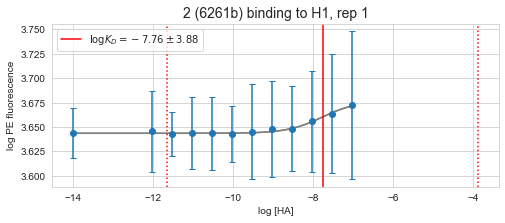

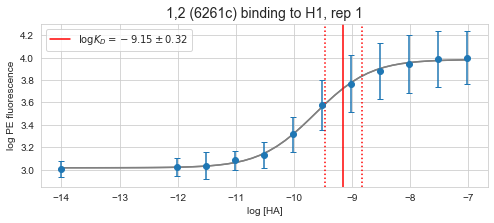

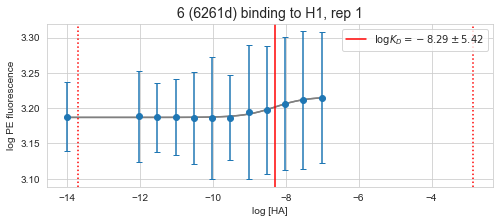

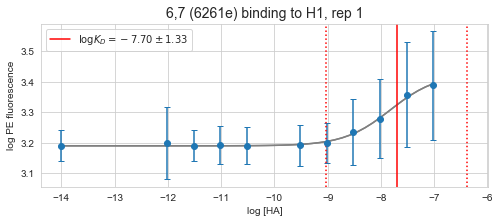

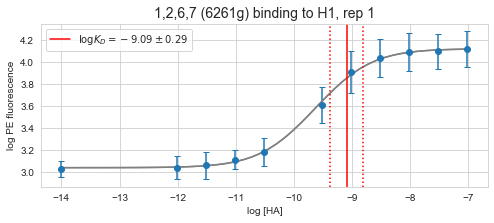

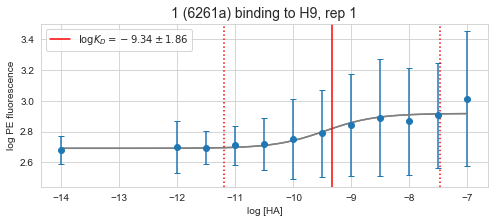

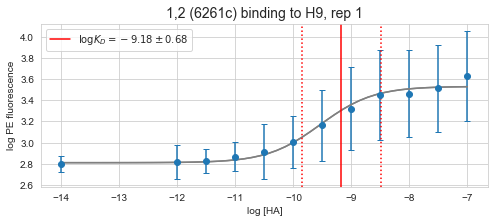

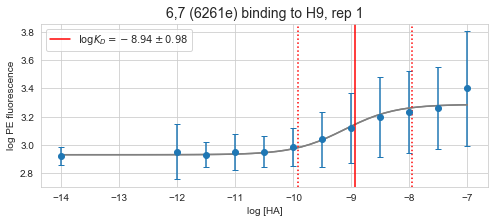

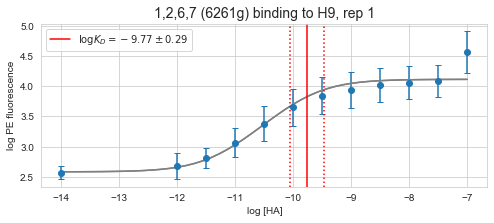

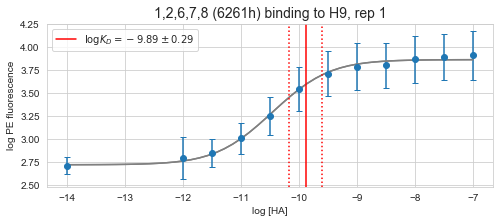

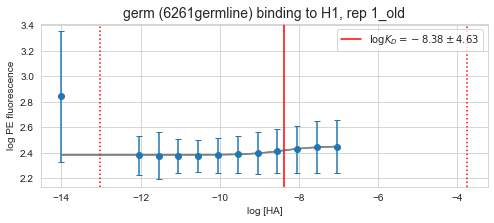

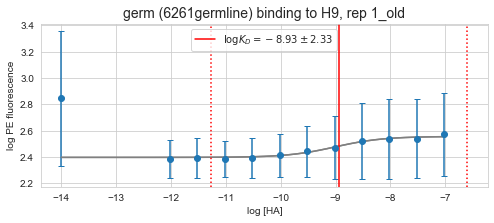

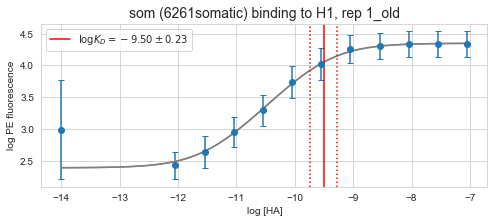

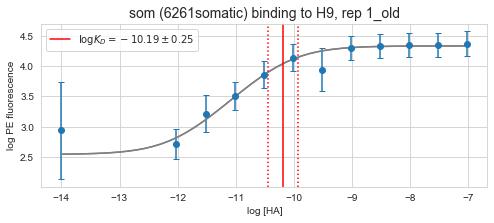

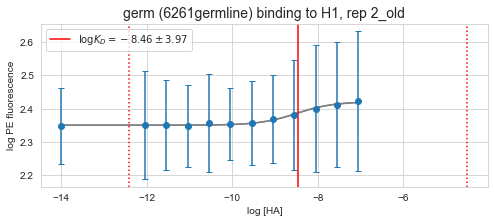

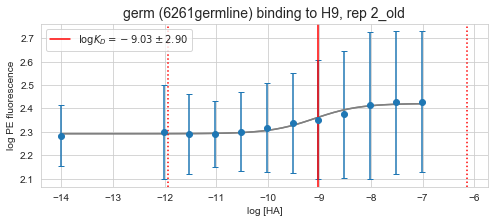

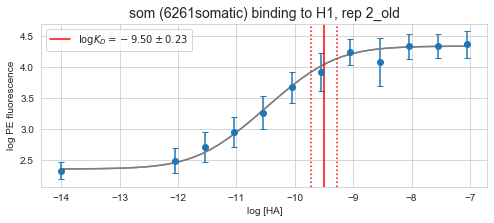

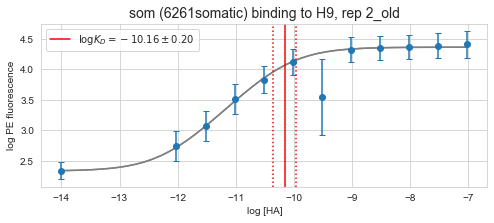

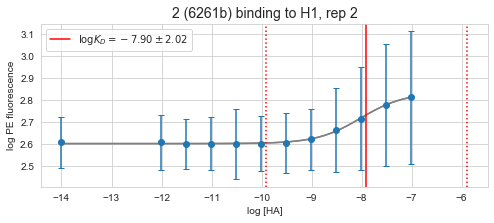

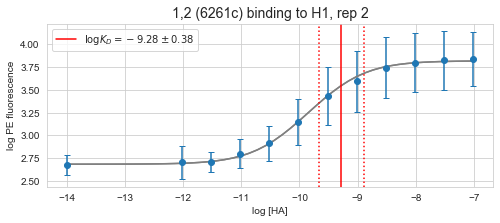

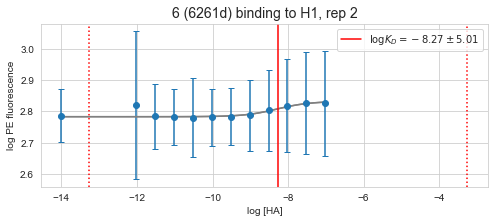

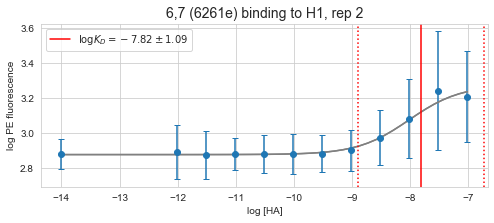

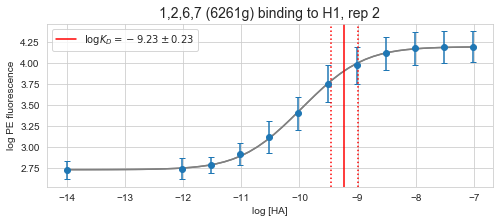

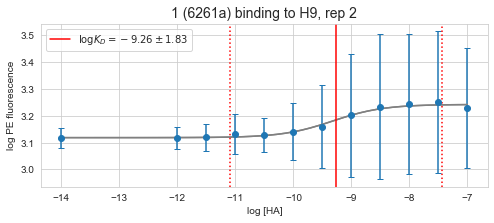

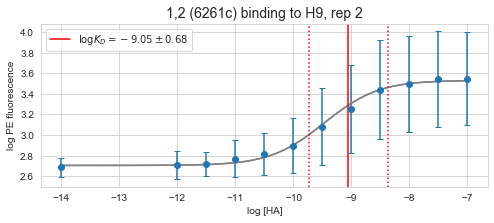

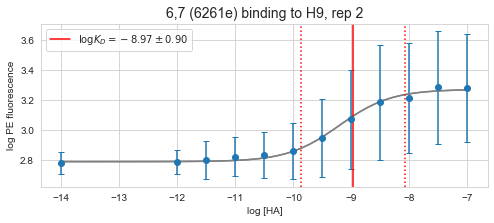

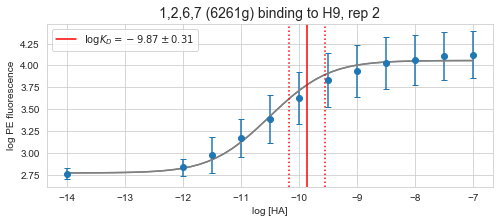

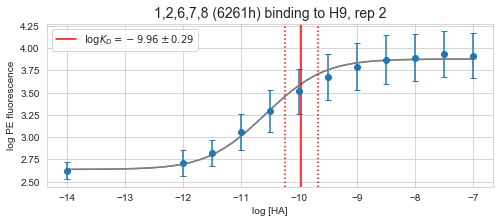

In [7]:
def sigmoid(c, Kd, A, B):
    return np.log10(A * (10**c/((10**c)+(10**Kd))) + B)

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

n_runs = run_list.shape[0]
run_list['KD'] = np.zeros(n_runs)
run_list['KD_err'] = np.zeros(n_runs)

for i,run in enumerate(runs):
    mean_log_fluor = [df['log_PE'].mean() for df in run]
    std_log_fluor = [df['log_PE'].std() for df in run]
    
    antigen = run_list['antigen'][i]
    #use the correct antigen concentration
    if i in range(10,18):
        antigen += '_angela'
    concs = (-concentrations_list[antigen]).copy()
    
    if i == 3:
        concs.drop(7, inplace=True)
    if i == 4:
        concs.drop(7, inplace=True)
    
    popt, pcov = scipy.optimize.curve_fit(sigmoid,
                                          concs,
                                          mean_log_fluor,
                                          p0=[(-9),10**(4),10**(1)],
                                          sigma=std_log_fluor,
                                          absolute_sigma=True,
                                          bounds = [((-14),1,1),((-5),10**(5),10**(5))],
                                          maxfev=400000)
    
    logKd = popt[0]
    logKd_err = np.sqrt(pcov[0][0])
    run_list.loc[i,'KD'] = logKd
    run_list.loc[i,'KD_err'] = logKd_err
    
    concs_plot = np.linspace(concs.min(), concs.max())
    
    plt.figure(figsize=(8,3))
    plt.errorbar(concs, mean_log_fluor, yerr=std_log_fluor, fmt='o', capsize=3)
    plt.plot(concs_plot, sigmoid(concs_plot, *popt), color='grey')
    plt.plot(concs_plot, sigmoid(concs_plot, *popt), color='grey')
    plt.axvline(logKd, linestyle='-', color='red',
               label=r'$\log K_D = %.2f \pm %.2f$' % (logKd, logKd_err))
    plt.axvline(logKd + logKd_err, linestyle=':', color='red')
    plt.axvline(logKd - logKd_err, linestyle=':', color='red')
    plt.xlabel('log [HA]')
    plt.ylabel('log PE fluorescence')
    plt.title('%s (6261%s) binding to %s, rep %s' %
              (run_list.loc[i,'shortname'], 
               run_list.loc[i,'mutant'],
               run_list.loc[i,'antigen'],
               run_list.loc[i,'replicate']),
              fontsize=14)
    plt.legend()
    plt.show()

## merge with titeseq data 

In [8]:
antigen_map = {'H1':'h1', 'H9':'h9'}
run_list['run_id'] = run_list.index
for row in run_list.index:
    antigen = run_list['antigen'][row]
    mutant = run_list['mutant'][row]
    if run_list['shortname'][row].endswith('syn'):
        continue
    if mutant == 'germline':
        mutant = 'm'
    if mutant == 'somatic':
        mutant = 'n'
    run_list.loc[row,'KD_titeseq'] = mut_list.loc[mutant,antigen_map[antigen] + '_mean']
    run_list.loc[row,'KD_titeseq_err'] = mut_list.loc[mutant,antigen_map[antigen] + '_sem']

In [10]:
results = run_list.set_index(['antigen', 'shortname', 'replicate']).sort_index()[['run_id', 'KD', 'KD_err', 'KD_titeseq', 'KD_titeseq_err']]
results.loc[results.KD > -7, 'KD'] = -7
results = results[results['KD_err'] < 1]
results.to_csv('fitted_Kds.csv')
results

run_id         KD    KD_err  KD_titeseq  \
antigen shortname replicate                                            
H1      1,2       1               1  -9.152523  0.321791    9.278592   
                  2              19  -9.277189  0.384465    9.278592   
        1,2,6,7   1               4  -9.092682  0.285362    9.343454   
                  2              22  -9.229987  0.230932    9.343454   
        som       1_old          12  -9.504139  0.233841    9.506654   
                  2_old          16  -9.503407  0.225267    9.506654   
H9      1,2       1               6  -9.176412  0.683471    9.067835   
                  2              24  -9.054685  0.680104    9.067835   
        1,2,6,7   1               8  -9.767006  0.289334    9.807098   
                  2              26  -9.866163  0.312003    9.807098   
        1,2,6,7,8 1               9  -9.885418  0.290101   10.001743   
                  2              27  -9.958268  0.289318   10.001743   
        6,7       1               7  -8.944757  0.982511    8.869847   
                  2              25  -8.970928  0.901182    8.869847   
        som       1_old          13 -10.190717  0.254492   10.094744   
                  2_old          17 -10.160267  0.202185   10.094744   

                             KD_titeseq_err  
antigen shortname replicate                  
H1      1,2       1                0.043819  
                  2                0.043819  
        1,2,6,7   1                0.015493  
                  2                0.015493  
        som       1_old            0.016688  
                  2_old            0.016688  
H9      1,2       1                0.144001  
                  2                0.144001  
        1,2,6,7   1                0.008562  
                  2                0.008562  
        1,2,6,7,8 1                0.024947  
                  2                0.024947  
        6,7       1                0.099096  
                  2                0.099096  
        som       1_old            0.014203  
                  2_old            0.014203

In [17]:
g = results.groupby(['antigen', 'shortname'])
results_merge = pd.DataFrame({
    'KD' : -g.mean()['KD'],
    'KD_err' : g.std()['KD'],
    'KD_titeseq' : g['KD_titeseq'].mean(),
    'KD_titeseq_err' : g['KD_titeseq_err'].mean()})
results_merge

KD    KD_err  KD_titeseq  KD_titeseq_err
antigen shortname                                                 
H1      1,2         9.214856  0.088152    9.278592        0.043819
        1,2,6,7     9.161335  0.097090    9.343454        0.015493
        som         9.503773  0.000517    9.506654        0.016688
H9      1,2         9.115549  0.086074    9.067835        0.144001
        1,2,6,7     9.816585  0.070114    9.807098        0.008562
        1,2,6,7,8   9.921843  0.051513   10.001743        0.024947
        6,7         8.957842  0.018506    8.869847        0.099096
        som        10.175492  0.021531   10.094744        0.014203

## plotting correlations between titeseq Kd and isogenic measurements

(5.5, 10.5)

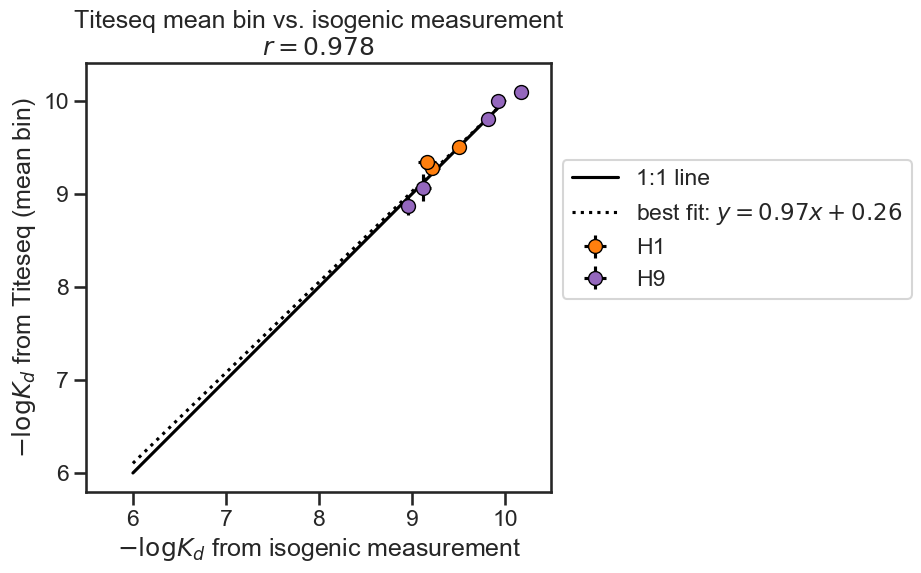

In [18]:
sns.set_context('talk')
mpl.rcParams['figure.dpi'] = 100
plot_list = results_merge[~results_merge['KD_titeseq'].isna()]
xaxis = 'KD'
yaxis = 'KD_titeseq'
xlabel = r'$-\log K_d$ from isogenic measurement'
ylabel = r'$-\log K_d$ from Titeseq (mean bin)'

plt.figure(figsize=(6,6))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(plot_list[xaxis], plot_list[yaxis])
xs = np.array([6,10])
plt.plot(xs, xs, 'k-', label='1:1 line')
plt.plot(xs, slope*xs + intercept, 'k:', label='best fit: $y=%0.2fx + %0.2f$' % (slope, intercept))

colordict = {'H1':'tab:orange', 'H9':'tab:purple'}
for i in []:
#for i in plot_list.index:
    plt.text(x=plot_list[xaxis][i] + 0.07,
             y=plot_list[yaxis][i] - 0.05,
             s=i[1],
             va='center',
             ha='left',
             color=colordict[i[0]],
             fontsize=14,
             alpha=0.8
            )
#plt.plot([6,10], [6,10], 'k:')
for ag,color in colordict.items():
    to_plot = plot_list.loc[ag,:]
    #plt.plot([], [], color, marker='o', ls='None', label=ag)
    plt.errorbar(x=to_plot[xaxis],
                 y=to_plot[yaxis],
                 xerr=to_plot[xaxis+'_err'],
                 yerr=to_plot[yaxis+'_err'],
                 linestyle='None',
                 marker='o',
                 markersize=10,
                 markeredgecolor='k',
                 label=ag,
                 ecolor='k',
                color=color)
import scipy.stats


plt.legend(bbox_to_anchor=(1,0.8), loc='upper left')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Titeseq mean bin vs. isogenic measurement\n$r=%0.3f$' % r_value)
plt.axis('square')
plt.xlim(5.5,10.5)
